In [1]:
import os
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from data_loaders import get_fertility, get_lifetables_ex
from figures_static import plot_national_fert_static
import numpy as np

mpl.rcParams['font.family'] = 'Helvetica'

stacked_asfr, tfr_df = get_fertility()
ex_df_all = get_lifetables_ex("total_nacional")

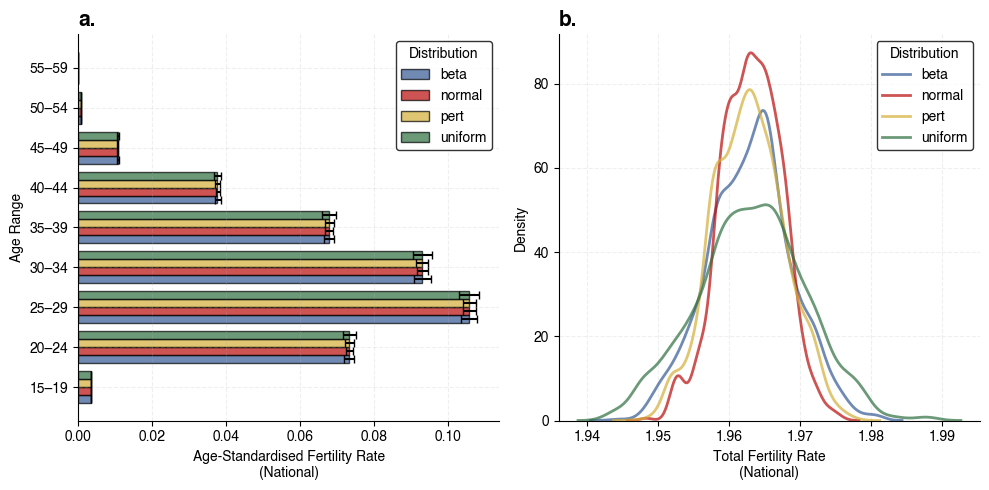

In [2]:
plot_national_fert_static(stacked_asfr, tfr_df)

In [3]:
asfr_dir = "../results/asfr"
dptos_asfr = sorted(
    name for name in os.listdir(asfr_dir)
    if os.path.isdir(os.path.join(asfr_dir, name))
)

def make_summary_asfr():
    records = []
    for d in dptos_asfr:
        beta_dir = os.path.join(asfr_dir, d, "draw", "beta")
        if not os.path.isdir(beta_dir):
            continue
        vals = []
        for fn in sorted(os.listdir(beta_dir)):
            if not fn.lower().endswith(".csv"):
                continue
            path = os.path.join(beta_dir, fn)
            try:
                df = pd.read_csv(path)
            except pd.errors.EmptyDataError:
                # skip empty files
                continue
            if df.shape[0] == 0 or df.shape[1] == 0:
                # skip files with no data
                continue
            # extract first row, last column (ASFR)
            vals.append(df['asfr'].sum()*5)
        records.append({
            "DPTO":       d,
            "min_asfr":   min(vals) if vals else float("nan"),
            "max_asfr":   max(vals) if vals else float("nan"),
            "mean_asfr":  sum(vals)/len(vals) if vals else float("nan"),
        })
    return (
        pd.DataFrame.from_records(records)
          .set_index("DPTO")
          .sort_values("mean_asfr", ascending=False)
    )

summary_asfr = make_summary_asfr()
data = [
    summary_asfr.loc[d, ['min_asfr', 'max_asfr', 'mean_asfr']].values
    for d in summary_asfr.index
]

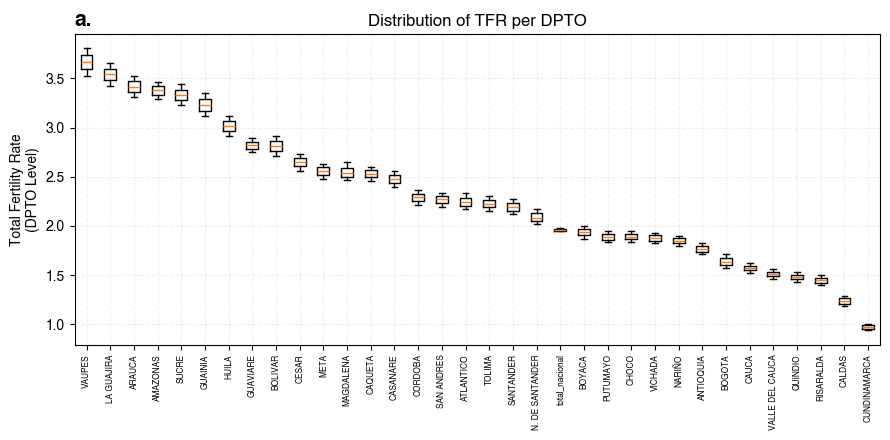

In [4]:
# Create and save the figure
fig, ax = plt.subplots(figsize=(9, 4.5))
ax.boxplot(data)
ax.set_xticklabels(summary_asfr.index, rotation=90, fontsize=6)
ax.set_ylabel('Total Fertility Rate\n(DPTO Level)')
ax.set_title('Distribution of TFR per DPTO')
ax.set_title('a.', loc='left', fontweight='bold', fontsize=15)
ax.grid(which='major', linestyle='--', alpha=0.2)
plt.tight_layout()
fig.savefig('../figures/TFR_per_DPTO.pdf')

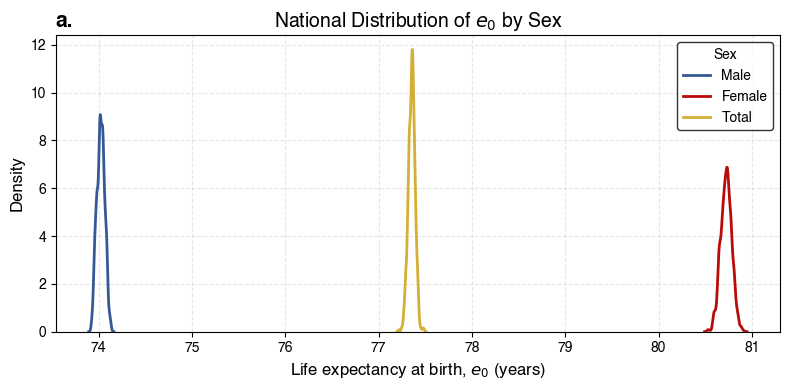

In [5]:
colors = ["#345995", "#B80C09", "#D4AF37", "#2E6F40"]  # one per prefix
male_cols   = [c for c in ex_df_all.columns if ('_M_' in c) and ('beta' in c)]
female_cols = [c for c in ex_df_all.columns if ('_F_' in c) and ('beta' in c)]
total_cols = [c for c in ex_df_all.columns if ('_T_' in c) and ('beta' in c)]

e0_male   = ex_df_all.iloc[0][male_cols]
e0_female = ex_df_all.iloc[0][female_cols]
e0_total = ex_df_all.iloc[0][total_cols]

fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(e0_male, ax=ax, linewidth=2, label='Male', color=colors[0])
sns.kdeplot(e0_female, ax=ax, linewidth=2, label='Female', color=colors[1])
sns.kdeplot(e0_total, ax=ax, linewidth=2, label='Total', color=colors[2])

# 3. Formatting
ax.set_xlabel('Life expectancy at birth, $e_0$ (years)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('National Distribution of $e_0$ by Sex', fontsize=14)
ax.legend(title='Sex', frameon=True, edgecolor='k')
ax.grid(True, linestyle='--', alpha=0.3)
ax.set_title('a.', loc='left', fontweight='bold', fontsize=15)
plt.tight_layout()
fig.savefig('../figures/national_e0_alldist.pdf')

In [6]:
lifetables_dir = "../results/lifetables"
dptos = sorted(
    name for name in os.listdir(lifetables_dir)
    if os.path.isdir(os.path.join(lifetables_dir, name))
)

records = []

# 2. For each DPTO, build three lists of ex-values
for d in tqdm(dptos, desc="DPTOs"):
    beta_dir = os.path.join(lifetables_dir, d, "draw", "beta")
    if not os.path.isdir(beta_dir):
        tqdm.write(f"Skipping {d!r}: no draw/beta directory")
        continue

    files = sorted(os.listdir(beta_dir))

    # Partition filenames by sex‐marker
    male_files   = [f for f in files if "_M_" in f and f.lower().endswith(".csv")]
    female_files = [f for f in files if "_F_" in f and f.lower().endswith(".csv")]
    total_files  = [f for f in files if "_T_" in f and f.lower().endswith(".csv")]

    # Helper to extract ex-values from a list of filenames
    def ex_list(filenames):
        vals = []
        for fn in filenames:
            df = pd.read_csv(os.path.join(beta_dir, fn))
            vals.append(df.iloc[0, -1])  # first row, last column
        return vals

    ex_M = ex_list(male_files)
    ex_F = ex_list(female_files)
    ex_T = ex_list(total_files)

    # 3. Compute min/max/mean for each category (or NaN if empty)
    def stats(xs):
        return (
            min(xs) if xs else float("nan"),
            max(xs) if xs else float("nan"),
            sum(xs)/len(xs) if xs else float("nan"),
        )

    min_M, max_M, mean_M = stats(ex_M)
    min_F, max_F, mean_F = stats(ex_F)
    min_T, max_T, mean_T = stats(ex_T)

    # 4. Record one row per DPTO
    records.append({
        "DPTO":    d,
        "min_M":   min_M,   "max_M":   max_M,   "mean_M":   mean_M,
        "min_F":   min_F,   "max_F":   max_F,   "mean_F":   mean_F,
        "min_T":   min_T,   "max_T":   max_T,   "mean_T":   mean_T,
    })

# 5. Build the final DataFrame
summary_df = (
    pd.DataFrame.from_records(records)
      .set_index("DPTO")
      .sort_values("mean_T", ascending=False)  # or by any column you prefer
)


DPTOs: 100%|████████████████████████████████████| 34/34 [03:39<00:00,  6.46s/it]


In [7]:
dptos = sorted(
    name for name in os.listdir(lifetables_dir)
    if os.path.isdir(os.path.join(lifetables_dir, name))
)

def make_summary(sex_marker):
    records = []
    for d in dptos:
        beta_dir = os.path.join(lifetables_dir, d, "draw", "beta")
        if not os.path.isdir(beta_dir):
            continue
        files = sorted(os.listdir(beta_dir))
        sex_files = [f for f in files if sex_marker in f and f.lower().endswith(".csv")]
        ex_vals = []
        for fn in sex_files:
            df = pd.read_csv(os.path.join(beta_dir, fn))
            ex_vals.append(df.iloc[0, -1])
        if ex_vals:
            prefix = sex_marker.strip("_")
            records.append({
                "DPTO":      d,
                f"min_{prefix}":  min(ex_vals),
                f"max_{prefix}":  max(ex_vals),
                f"mean_{prefix}": sum(ex_vals)/len(ex_vals),
            })
    return (
        pd.DataFrame.from_records(records)
          .set_index("DPTO")
          .sort_values(f"mean_{sex_marker.strip('_')}", ascending=False)
    )

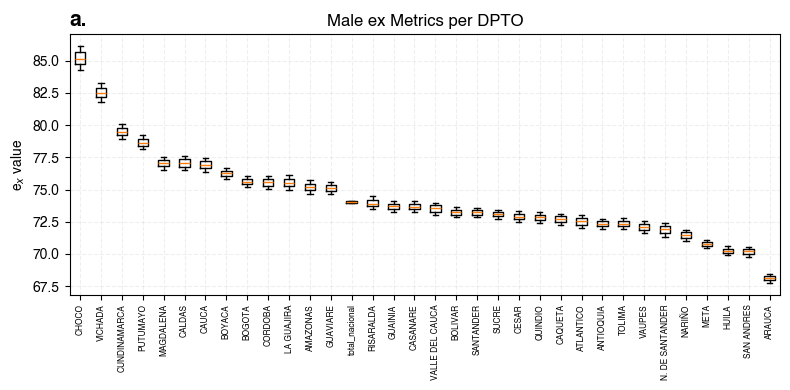

In [8]:
summary_M = make_summary("_M_")
fig, ax = plt.subplots(figsize=(max(8, len(summary_M) * 0.2), 4), sharey=True)
data = [summary_M.loc[d, ['min_M','max_M','mean_M']].values for d in summary_M.index]
ax.boxplot(data)
ax.set_xticklabels(summary_M.index, rotation=90, fontsize=6)
ax.set_title("Male ex Metrics per DPTO")
ax.set_ylabel(r"e$_x$ value")
ax.set_title('a.', loc='left', fontweight='bold', fontsize=15)
ax.grid(which='major', linestyle='--', alpha=0.2)
plt.tight_layout()
fig.savefig('../figures/male_ex_metrics_by_DPTO.pdf')

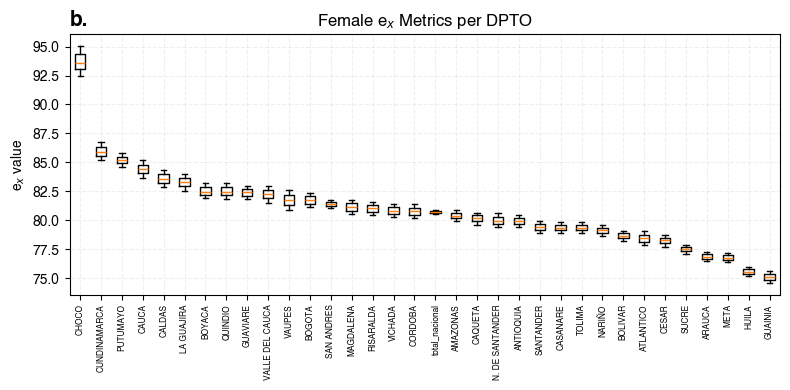

In [9]:
summary_F = make_summary("_F_")
fig, ax = plt.subplots(figsize=(max(8, len(summary_F) * 0.2), 4), sharey=True)
data = [summary_F.loc[d, ['min_F','max_F','mean_F']].values for d in summary_F.index]
ax.boxplot(data)
ax.set_xticklabels(summary_F.index, rotation=90, fontsize=6)
ax.set_title(r"Female e$_x$ Metrics per DPTO")
ax.set_ylabel(r"e$_x$ value")
ax.set_title('b.', loc='left', fontweight='bold', fontsize=15)
ax.grid(which='major', linestyle='--', alpha=0.2)
plt.tight_layout()
fig.savefig('../figures/female_ex_metrics_by_DPTO.pdf')

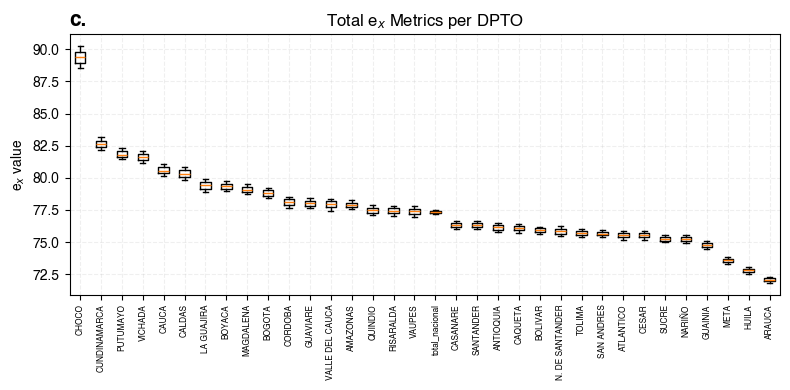

In [10]:
summary_T = make_summary("_T_")
fig, ax = plt.subplots(figsize=(max(8, len(summary_T) * 0.2), 4), sharey=True)
data = [summary_T.loc[d, ['min_T','max_T','mean_T']].values for d in summary_T.index]
ax.boxplot(data)
ax.set_xticklabels(summary_T.index, rotation=90, fontsize=6)
ax.set_title(r"Total e$_x$ Metrics per DPTO")
ax.set_title('c.', loc='left', fontweight='bold', fontsize=15)
ax.grid(which='major', linestyle='--', alpha=0.2)
ax.set_ylabel(r"e$_x$ value")
plt.tight_layout()
fig.savefig('../figures/total_ex_metrics_by_DPTO.pdf')

In [11]:
import os
import pandas as pd
from tqdm import tqdm

# 1. Base directory for projections
base_dir = "../results/projections"

# 2. Discover all DPTO folders
dptos = sorted(
    name for name in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, name))
)

# 3. Prepare the nested dict
#    totals[DPTO][sex_folder][distribution][horizon] = [totals across draws]
totals = {}

for d in tqdm(dptos, desc="DPTOs"):
    totals[d] = {}
    dpath = os.path.join(base_dir, d)

    # 4. Find sex‐specific subdirectories
    for sex_folder in sorted(os.listdir(dpath)):
        sex_path = os.path.join(dpath, sex_folder)
        if not (sex_folder.startswith("age_structures_df") and os.path.isdir(sex_path)):
            continue

        totals[d][sex_folder] = {}
        draw_root = os.path.join(sex_path, "draw")

        # 5. Loop over each distribution under draw/
        for dist in [#"beta",
            "pert"#, "uniform", "normal"
        ]:
            dist_dir = os.path.join(draw_root, dist)
            if not os.path.isdir(dist_dir):
                tqdm.write(f"  → Skip {d}/{sex_folder}/{dist}: not found")
                continue

            # Accumulate horizon‐totals across draws
            horizon_totals = {}
            for fn in sorted(os.listdir(dist_dir)):
                if not fn.lower().endswith(".csv"):
                    continue
                df = pd.read_csv(os.path.join(dist_dir, fn))
                # assume first column = 'age'; sum down all other columns
                col_sums = df.iloc[:, 1:].sum(axis=0)
                for horizon, total in col_sums.items():
                    horizon_totals.setdefault(horizon, []).append(total)

            totals[d][sex_folder][dist] = horizon_totals

'''
# Example: for total_nacional, female, uniform draws:
example = totals["total_nacional"]["age_structures_df_F"]["uniform"]
for h, values in example.items():
    print(f"{h} → {len(values)} draws, first three: {values[:3]}")
'''

DPTOs: 100%|████████████████████████████████████| 34/34 [05:08<00:00,  9.07s/it]


'\n# Example: for total_nacional, female, uniform draws:\nexample = totals["total_nacional"]["age_structures_df_F"]["uniform"]\nfor h, values in example.items():\n    print(f"{h} → {len(values)} draws, first three: {values[:3]}")\n'

DPTOs:  12%|████▎                                | 4/34 [01:32<11:36, 23.22s/it]


KeyboardInterrupt: 

In [ ]:
# EXAMPLE: transform to DataFrame for one case
# e.g. d = "total_nacional", sex_folder = "age_structures_df_F", dist = "pert"
example = totals["total_nacional"]["age_structures_df_F"]["pert"]
ages = sorted(example.keys())
horizons = sorted(next(iter(example.values())).keys())

df = pd.DataFrame(
    index=ages,
    columns=horizons,
)

for age in ages:
    for horizon in horizons:
        df.at[age, horizon] = example[age][horizon]

# you may wish to store df to pickle or other format
print(df)


In [12]:
'''
# 1. One Figure+Axes for both sexes
fig, ax = plt.subplots(figsize=(10, 3.5))


horizon_dict = totals["total_nacional"][f"age_structures_df_F"]['beta']
stats = []
for h, vals in horizon_dict.items():
    arr = np.array(vals)
    stats.append({
        "horizon": h,
        "Min":   arr.min(),
        "Mean":  arr.mean(),
        "Max":   arr.max()
    })
stats = pd.DataFrame(stats).set_index("horizon")
stats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])
ax.plot(stats.index, stats["Min"],  label=f"Female Min/Max",  linestyle="--", color=colors[0], linewidth=0.5)
ax.plot(stats.index, stats["Mean"], label=f"Female Mean", linestyle="-", color=colors[0], linewidth=1)
ax.plot(stats.index, stats["Max"],  label="",  linestyle="--", color=colors[0], linewidth=0.5)

horizon_dict = totals["total_nacional"][f"age_structures_df_M"]['beta']
stats = []
for h, vals in horizon_dict.items():
    arr = np.array(vals)
    stats.append({
        "horizon": h,
        "Min":   arr.min(),
        "Mean":  arr.mean(),
        "Max":   arr.max()
    })
stats = pd.DataFrame(stats).set_index("horizon")
stats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])
ax.plot(stats.index, stats["Min"],  label=f"Male Min/Max",  linestyle="--", color=colors[1], linewidth=0.5)
ax.plot(stats.index, stats["Mean"], label=f"Male Mean", linestyle="-", color=colors[1], linewidth=1)
ax.plot(stats.index, stats["Max"], linestyle="--", color=colors[1], linewidth=0.5)

    
# 4. Finalize
ax.set_title("total_nacional: Female vs Male (Min/Mean/Max)")
ax.set_xlabel("Horizon (t+)")
ax.set_ylabel("Total Population")
ax.legend(ncol=1, fontsize=8, edgecolor='k')

ax.set_title('Projections at the National Level\n(Beta Resampling)', fontsize=11)
ax.set_title('a.', loc='left', fontweight='bold', fontsize=15)
ax.grid(which='major', linestyle='--', alpha=0.2)

import matplotlib.ticker as mtick

ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f"{x/1e6:.0f}Mn")
)

import matplotlib.ticker as mticker
#ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

horizons = stats.index  # e.g. ['t+0','t+1',…,'t+N']
ax.set_xticks(range(0, len(horizons), 5)); 
ax.set_xticklabels(horizons[::5], rotation=90, fontsize=10)

sns.despine()
fig.savefig('../figures/national_projections_beta.pdf')
'''

'\n# 1. One Figure+Axes for both sexes\nfig, ax = plt.subplots(figsize=(10, 3.5))\n\n\nhorizon_dict = totals["total_nacional"][f"age_structures_df_F"][\'beta\']\nstats = []\nfor h, vals in horizon_dict.items():\n    arr = np.array(vals)\n    stats.append({\n        "horizon": h,\n        "Min":   arr.min(),\n        "Mean":  arr.mean(),\n        "Max":   arr.max()\n    })\nstats = pd.DataFrame(stats).set_index("horizon")\nstats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])\nax.plot(stats.index, stats["Min"],  label=f"Female Min/Max",  linestyle="--", color=colors[0], linewidth=0.5)\nax.plot(stats.index, stats["Mean"], label=f"Female Mean", linestyle="-", color=colors[0], linewidth=1)\nax.plot(stats.index, stats["Max"],  label="",  linestyle="--", color=colors[0], linewidth=0.5)\n\nhorizon_dict = totals["total_nacional"][f"age_structures_df_M"][\'beta\']\nstats = []\nfor h, vals in horizon_dict.items():\n    arr = np.array(vals)\n    stats.append({\n        

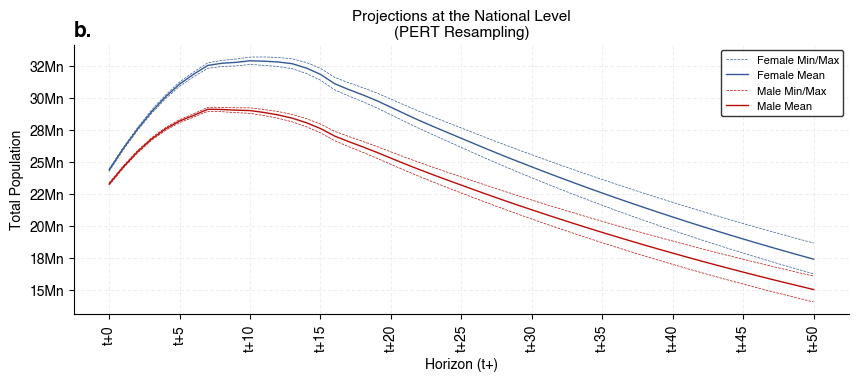

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. One Figure+Axes for both sexes
fig, ax = plt.subplots(figsize=(10, 3.5))


horizon_dict = totals["total_nacional"][f"age_structures_df_F"]['pert']
stats = []
for h, vals in horizon_dict.items():
    arr = np.array(vals)
    stats.append({
        "horizon": h,
        "Min":   arr.min(),
        "Mean":  arr.mean(),
        "Max":   arr.max()
    })

df_PERT = pd.DataFrame()
stats = pd.DataFrame(stats).set_index("horizon")
stats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])
ax.plot(stats.index, stats["Min"],  label=f"Female Min/Max",  linestyle="--", color=colors[0], linewidth=0.5)
ax.plot(stats.index, stats["Mean"], label=f"Female Mean", linestyle="-", color=colors[0], linewidth=1)
ax.plot(stats.index, stats["Max"],  label="",  linestyle="--", color=colors[0], linewidth=0.5)

df['Min_F'] = stats["Min"]
df['Mean_F'] = stats["Mean"]
df['Max_F'] = stats["Max"]
horizon_dict = totals["total_nacional"][f"age_structures_df_M"]['pert']
stats = []
for h, vals in horizon_dict.items():
    arr = np.array(vals)
    stats.append({
        "horizon": h,
        "Min":   arr.min(),
        "Mean":  arr.mean(),
        "Max":   arr.max()
    })
stats = pd.DataFrame(stats).set_index("horizon")
stats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])
ax.plot(stats.index, stats["Min"],  label=f"Male Min/Max",  linestyle="--", color=colors[1], linewidth=0.5)
ax.plot(stats.index, stats["Mean"], label=f"Male Mean", linestyle="-", color=colors[1], linewidth=1)
ax.plot(stats.index, stats["Max"], linestyle="--", color=colors[1], linewidth=0.5)

df['Min_M'] = stats["Min"]
df['Mean_M'] = stats["Mean"]
df['Max_M'] = stats["Max"]
df.to_csv('PERT_closed_projections.csv')
    
# 4. Finalize
ax.set_title("total_nacional: Female vs Male (Min/Mean/Max)")
ax.set_xlabel("Horizon (t+)")
ax.set_ylabel("Total Population")
ax.legend(ncol=1, fontsize=8, edgecolor='k')

ax.set_title('Projections at the National Level\n(PERT Resampling)', fontsize=11)
ax.set_title('b.', loc='left', fontweight='bold', fontsize=15)
ax.grid(which='major', linestyle='--', alpha=0.2)

import matplotlib.ticker as mtick

ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f"{x/1e6:.0f}Mn")
)

import matplotlib.ticker as mticker
#ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

horizons = stats.index  # e.g. ['t+0','t+1',…,'t+N']
ax.set_xticks(range(0, len(horizons), 5)); 
ax.set_xticklabels(horizons[::5], rotation=90, fontsize=10)

sns.despine()
fig.savefig('../figures/national_projections_PERT.pdf')


In [14]:
def horizon_stats(horizon_dict, suffix):
    """
    Build a statistics table for one sex and return it
    with the columns suffixed (_F or _M).
    """
    out = (
        pd.DataFrame([
            {"horizon": h,
             "Min":  np.min(vals),
             "Mean": np.mean(vals),
             "Max":  np.max(vals)}
            for h, vals in horizon_dict.items()
        ])
        .set_index("horizon")
        .sort_index(key=lambda idx: idx.str.lstrip("t+").astype(int))
        .add_suffix(f"_{suffix}")
    )
    return out


female_stats = horizon_stats(
    totals["total_nacional"]["age_structures_df_F"]["pert"], "F"
)
male_stats   = horizon_stats(
    totals["total_nacional"]["age_structures_df_M"]["pert"], "M"
)

stats_df = female_stats.join(male_stats)          # one tidy table
stats_df.to_csv("PERT_closed_projections_stats.csv")


In [23]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Root paths
base_dir = "../results/projections/total_nacional"
sex_folders = ["age_structures_df_F", "age_structures_df_M"]

for sex_folder in sex_folders:
    dist_dir = os.path.join(base_dir, sex_folder, "draw", "pert")
    if not os.path.isdir(dist_dir):
        raise FileNotFoundError(f"{dist_dir} does not exist")

    tqdm.write(f"Processing {dist_dir}")

    # nested dict: age -> horizon -> list of draws
    age_horizon_values = {}

    for fn in tqdm(sorted(os.listdir(dist_dir)), desc=f"{sex_folder} draws"):
        if not fn.lower().endswith(".csv"):
            continue
        df = pd.read_csv(os.path.join(dist_dir, fn))

        ages = df.iloc[:, 0]
        horizons = df.columns[1:]

        for i, age in enumerate(ages):
            for horizon in horizons:
                val = df.loc[i, horizon]
                age_horizon_values.setdefault(age, {}).setdefault(horizon, []).append(val)

    # determine full set of ages and horizons
    ages_all = sorted(age_horizon_values.keys())
    horizons_all = sorted(
        next(iter(age_horizon_values.values())).keys(),
        key=lambda x: int(x.split("+")[1])
    )
    # prepare DataFrames
    df_min = pd.DataFrame(index=ages_all, columns=horizons_all, dtype=float)
    df_median = pd.DataFrame(index=ages_all, columns=horizons_all, dtype=float)
    df_max = pd.DataFrame(index=ages_all, columns=horizons_all, dtype=float)

    for age in ages_all:
        for horizon in horizons_all:
            values_arr = np.array(age_horizon_values[age][horizon])
            df_min.at[age, horizon] = np.min(values_arr)
            df_median.at[age, horizon] = np.median(values_arr)
            df_max.at[age, horizon] = np.max(values_arr)

    # output path
    out_dir = os.path.join(base_dir, sex_folder, "summary")
    os.makedirs(out_dir, exist_ok=True)

    df_min.to_csv(os.path.join(out_dir, "age_horizon_min.csv"))
    df_median.to_csv(os.path.join(out_dir, "age_horizon_median.csv"))
    df_max.to_csv(os.path.join(out_dir, "age_horizon_max.csv"))

    tqdm.write(f"Saved summaries for {sex_folder} in {out_dir}")


Processing ../results/projections/total_nacional/age_structures_df_F/draw/pert


age_structures_df_F draws: 100%|███████████| 2501/2501 [00:11<00:00, 224.27it/s]


Saved summaries for age_structures_df_F in ../results/projections/total_nacional/age_structures_df_F/summary
Processing ../results/projections/total_nacional/age_structures_df_M/draw/pert


age_structures_df_M draws: 100%|███████████| 2500/2500 [00:13<00:00, 187.06it/s]


Saved summaries for age_structures_df_M in ../results/projections/total_nacional/age_structures_df_M/summary


In [15]:

'''
# 1. One Figure+Axes for both sexes
fig, ax = plt.subplots(figsize=(10, 3.5))


horizon_dict = totals["total_nacional"][f"age_structures_df_F"]['normal']
stats = []
for h, vals in horizon_dict.items():
    arr = np.array(vals)
    stats.append({
        "horizon": h,
        "Min":   arr.min(),
        "Mean":  arr.mean(),
        "Max":   arr.max()
    })
stats = pd.DataFrame(stats).set_index("horizon")
stats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])
ax.plot(stats.index, stats["Min"],  label=f"Female Min/Max",  linestyle="--", color=colors[0], linewidth=0.5)
ax.plot(stats.index, stats["Mean"], label=f"Female Mean", linestyle="-", color=colors[0], linewidth=1)
ax.plot(stats.index, stats["Max"],  label="",  linestyle="--", color=colors[0], linewidth=0.5)

horizon_dict = totals["total_nacional"][f"age_structures_df_M"]['normal']
stats = []
for h, vals in horizon_dict.items():
    arr = np.array(vals)
    stats.append({
        "horizon": h,
        "Min":   arr.min(),
        "Mean":  arr.mean(),
        "Max":   arr.max()
    })
stats = pd.DataFrame(stats).set_index("horizon")
stats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])
ax.plot(stats.index, stats["Min"],  label=f"Male Min/Max",  linestyle="--", color=colors[1], linewidth=0.5)
ax.plot(stats.index, stats["Mean"], label=f"Male Mean", linestyle="-", color=colors[1], linewidth=1)
ax.plot(stats.index, stats["Max"], linestyle="--", color=colors[1], linewidth=0.5)

    
# 4. Finalize
ax.set_title("total_nacional: Female vs Male (Min/Mean/Max)")
ax.set_xlabel("Horizon (t+)")
ax.set_ylabel("Total Population")
ax.legend(ncol=1, fontsize=8, edgecolor='k')

ax.set_title('Projections at the National Level\n(Normal Resampling)', fontsize=11)
ax.set_title('c.', loc='left', fontweight='bold', fontsize=15)
ax.grid(which='major', linestyle='--', alpha=0.2)

import matplotlib.ticker as mtick

ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f"{x/1e6:.0f}Mn")
)

import matplotlib.ticker as mticker
#ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

horizons = stats.index  # e.g. ['t+0','t+1',…,'t+N']
ax.set_xticks(range(0, len(horizons), 5)); 
ax.set_xticklabels(horizons[::5], rotation=90, fontsize=10)

sns.despine()

fig.savefig('../figures/national_projections_normal.pdf')
'''

'\n# 1. One Figure+Axes for both sexes\nfig, ax = plt.subplots(figsize=(10, 3.5))\n\n\nhorizon_dict = totals["total_nacional"][f"age_structures_df_F"][\'normal\']\nstats = []\nfor h, vals in horizon_dict.items():\n    arr = np.array(vals)\n    stats.append({\n        "horizon": h,\n        "Min":   arr.min(),\n        "Mean":  arr.mean(),\n        "Max":   arr.max()\n    })\nstats = pd.DataFrame(stats).set_index("horizon")\nstats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])\nax.plot(stats.index, stats["Min"],  label=f"Female Min/Max",  linestyle="--", color=colors[0], linewidth=0.5)\nax.plot(stats.index, stats["Mean"], label=f"Female Mean", linestyle="-", color=colors[0], linewidth=1)\nax.plot(stats.index, stats["Max"],  label="",  linestyle="--", color=colors[0], linewidth=0.5)\n\nhorizon_dict = totals["total_nacional"][f"age_structures_df_M"][\'normal\']\nstats = []\nfor h, vals in horizon_dict.items():\n    arr = np.array(vals)\n    stats.append({\n    

In [16]:
'''
# 1. One Figure+Axes for both sexes
fig, ax = plt.subplots(figsize=(10, 3.5))


horizon_dict = totals["total_nacional"][f"age_structures_df_F"]['uniform']
stats = []
for h, vals in horizon_dict.items():
    arr = np.array(vals)
    stats.append({
        "horizon": h,
        "Min":   arr.min(),
        "Mean":  arr.mean(),
        "Max":   arr.max()
    })
stats = pd.DataFrame(stats).set_index("horizon")
stats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])
ax.plot(stats.index, stats["Min"],  label=f"Female Min/Max",  linestyle="--", color=colors[0], linewidth=0.5)
ax.plot(stats.index, stats["Mean"], label=f"Female Mean", linestyle="-", color=colors[0], linewidth=1)
ax.plot(stats.index, stats["Max"],  label="",  linestyle="--", color=colors[0], linewidth=0.5)

horizon_dict = totals["total_nacional"][f"age_structures_df_M"]['uniform']
stats = []
for h, vals in horizon_dict.items():
    arr = np.array(vals)
    stats.append({
        "horizon": h,
        "Min":   arr.min(),
        "Mean":  arr.mean(),
        "Max":   arr.max()
    })
stats = pd.DataFrame(stats).set_index("horizon")
stats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])
ax.plot(stats.index, stats["Min"],  label=f"Male Min/Max",  linestyle="--", color=colors[1], linewidth=0.5)
ax.plot(stats.index, stats["Mean"], label=f"Male Mean", linestyle="-", color=colors[1], linewidth=1)
ax.plot(stats.index, stats["Max"], linestyle="--", color=colors[1], linewidth=0.5)

    
# 4. Finalize
ax.set_title("total_nacional: Female vs Male (Min/Mean/Max)")
ax.set_xlabel("Horizon (t+)")
ax.set_ylabel("Total Population")
ax.legend(ncol=1, fontsize=8, edgecolor='k')

ax.set_title('Projections at the National Level\n(Uniform Resampling)', fontsize=11)
ax.set_title('d.', loc='left', fontweight='bold', fontsize=15)
ax.grid(which='major', linestyle='--', alpha=0.2)

import matplotlib.ticker as mtick

ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, pos: f"{x/1e6:.0f}Mn")
)

import matplotlib.ticker as mticker
#ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

horizons = stats.index  # e.g. ['t+0','t+1',…,'t+N']
ax.set_xticks(range(0, len(horizons), 5)); 
ax.set_xticklabels(horizons[::5], rotation=90, fontsize=10)

sns.despine()
fig.savefig('../figures/national_projections_uniform.pdf')
'''

'\n# 1. One Figure+Axes for both sexes\nfig, ax = plt.subplots(figsize=(10, 3.5))\n\n\nhorizon_dict = totals["total_nacional"][f"age_structures_df_F"][\'uniform\']\nstats = []\nfor h, vals in horizon_dict.items():\n    arr = np.array(vals)\n    stats.append({\n        "horizon": h,\n        "Min":   arr.min(),\n        "Mean":  arr.mean(),\n        "Max":   arr.max()\n    })\nstats = pd.DataFrame(stats).set_index("horizon")\nstats = stats.sort_index(key=lambda idx: [int(lbl.lstrip("t+")) for lbl in idx])\nax.plot(stats.index, stats["Min"],  label=f"Female Min/Max",  linestyle="--", color=colors[0], linewidth=0.5)\nax.plot(stats.index, stats["Mean"], label=f"Female Mean", linestyle="-", color=colors[0], linewidth=1)\nax.plot(stats.index, stats["Max"],  label="",  linestyle="--", color=colors[0], linewidth=0.5)\n\nhorizon_dict = totals["total_nacional"][f"age_structures_df_M"][\'uniform\']\nstats = []\nfor h, vals in horizon_dict.items():\n    arr = np.array(vals)\n    stats.append({\n  